In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd("/ai/data/wuqiao/clinical_sample/WES/RAW_VCF/MT_analysis_2025.5.14_adjust_annotation/paired code and results_adjusted")

In [3]:
mutation=read.table("data/190 samples adjacent tumor paired exon mutation.csv",sep=",",quote = "\"",header=T)

In [4]:
print(head(mutation))

       ID        Sample    class  Chr Start End Ref        Alt
1 1288251 KY-WES-137045 adjacent chrM   567 567   A          C
2 1288251 KY-WES-137045 adjacent chrM   567 567   A          C
3 1288251 KY-WES-137045 adjacent chrM   567 567   A ACCCCCCCCC
4 1288251 KY-WES-137045 adjacent chrM   567 567   A ACCCCCCCCC
5 1288251 KY-WES-137045 adjacent chrM   310 310   T          C
6 1288251 KY-WES-137045 adjacent chrM   310 310   T          C
                                               Alt_all
1 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
2 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
3 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
4 ACCCC,C,ACCCCC,ACCCCCC,ACCCCCCC,ACCCCCCCC,ACCCCCCCCC
5                                                 C,TC
6                                                 C,TC
               Mutation.Class Func.MT_ensGene Gene.MT_ensGene
1 Substitution (Transversion)        upstream            RNR1
2 Substitution (Transversion)        upstream     

In [5]:
# 计算每个基因在每个样本中的突变数目
AF=unique(mutation[,c("Sample","class","Gene.MT_ensGene","ExonicFunc.MT_ensGene","AF_value")])

In [16]:
# Step 1: 先获取满足条件的 Gene.MT_ensGene 列表（只基于 tumor 样本）
valid_genes <- AF %>%
  filter(
    class == "tumor",
    !is.na(ExonicFunc.MT_ensGene),
    ExonicFunc.MT_ensGene != "",
    Gene.MT_ensGene != "missing"
  ) %>%
  pull(Gene.MT_ensGene) %>%
  unique()

In [17]:
valid_genes

[1] "COX1" "ND4"  "ATP6" "ND5"  "ND3"  "COX2" "ATP8" "ND1"  "COX3" "ND2" 
[11] "ND6"  "CYTB" "ND4L"

In [18]:
AF_filter=AF %>%
  filter(Gene.MT_ensGene %in% valid_genes, ExonicFunc.MT_ensGene != "")

In [20]:
# Step 2: 然后在所有样本中计算这些基因的 Average_AF
af_means <- AF_filter %>%
filter(Gene.MT_ensGene %in% valid_genes) %>%
group_by(Sample, class, Gene.MT_ensGene) %>%
summarise(Average_AF = mean(AF_value, na.rm = TRUE), .groups = "drop")

In [22]:
tail(af_means)

Sample,class,Gene.MT_ensGene,Average_AF
<chr>,<chr>,<chr>,<dbl>
WES-K84481,tumor,ND4,0.106000
WES-K84482,adjacent,ATP6,0.985000
WES-K84482,adjacent,ND2,0.999000
WES-K84483,tumor,CYTB,0.001673
WES-K84483,tumor,ND4,0.972000
WES-K84483,tumor,ND5,0.002977


In [23]:
write.table(af_means,"data/AF of each gene in paired each sample_exon gene.csv",sep=",",quote=F,row.names=F)

In [24]:
# 为每个基因在不同类别中计算平均突变数和95%置信区间
summary_stats <- af_means %>%
    group_by(Gene.MT_ensGene, class) %>%
    summarise(
        avg_count = mean(Average_AF),
        ci_lower = avg_count - 1.96 * sd(Average_AF) / sqrt(n()),
        ci_upper = avg_count + 1.96 * sd(Average_AF) / sqrt(n()),
        .groups = 'drop'
    )

In [25]:
summary_stats 

Gene.MT_ensGene,class,avg_count,ci_lower,ci_upper
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ATP6,adjacent,0.82500000,0.5717919991,1.0782080
ATP6,tumor,0.67712183,0.4024837584,0.9517599
ATP8,adjacent,0.53000000,-0.3892400000,1.4492400
ATP8,tumor,0.70700000,NA,NA
COX1,adjacent,0.62050000,0.0704184547,1.1705815
COX1,tumor,0.34544781,0.1894398550,0.5014558
COX2,adjacent,1.00000000,NA,NA
COX2,tumor,0.27562500,0.0594895484,0.4917605
COX3,adjacent,0.05824367,0.0005115501,0.1159758


In [26]:
# Step 3: 构建所有基因与 class 的组合，保留并集
gene_class_combinations <- expand.grid(
  Gene.MT_ensGene = unique(af_means$Gene.MT_ensGene[af_means$Gene.MT_ensGene != "missing"]),
  class = unique(af_means$class),
  stringsAsFactors = FALSE
)

# Step 4: 合并后缺失处为 NA
summary_stats_complete <- gene_class_combinations %>%
  left_join(summary_stats, by = c("Gene.MT_ensGene", "class"))

In [27]:
print(summary_stats_complete)

   Gene.MT_ensGene    class  avg_count      ci_lower  ci_upper
1              ND6    tumor 0.30214333 -0.0726046173 0.6768913
2              ND5    tumor 0.44182217  0.3384516424 0.5451927
3              ND2    tumor 0.70482143  0.5067796205 0.9028632
4              ND3    tumor 0.23343900  0.0145003964 0.4523776
5             CYTB    tumor 0.15587316  0.0738661328 0.2378802
6              ND1    tumor 0.34234119  0.2005221361 0.4841602
7              ND4    tumor 0.40188122  0.2519617223 0.5518007
8             COX2    tumor 0.27562500  0.0594895484 0.4917605
9             ATP6    tumor 0.67712183  0.4024837584 0.9517599
10            COX3    tumor 0.33353373  0.1291340978 0.5379334
11            COX1    tumor 0.34544781  0.1894398550 0.5014558
12            ND4L    tumor 0.22350000 -0.0093904243 0.4563904
13            ATP8    tumor 0.70700000            NA        NA
14             ND6 adjacent 0.33409533 -0.3155520887 0.9837428
15             ND5 adjacent 0.29151243 -0.0186749178 0.

In [28]:
write.table(summary_stats_complete,"data/average AF of each gene in paired each sample_exon gene.csv",sep=",",quote=F,row.names=F)

In [29]:
# 分别绘制 adjacent 类别的分布图
adjacent_stats <- summary_stats_complete %>%
  filter(class == "adjacent") %>%
  arrange(desc(avg_count)) %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = unique(Gene.MT_ensGene)))

In [31]:
print(adjacent_stats)

   Gene.MT_ensGene    class  avg_count      ci_lower  ci_upper
1             COX2 adjacent 1.00000000            NA        NA
2             ATP6 adjacent 0.82500000  0.5717919991 1.0782080
3             COX1 adjacent 0.62050000  0.0704184547 1.1705815
4              ND1 adjacent 0.54200000 -0.2910000000 1.3750000
5             ATP8 adjacent 0.53000000 -0.3892400000 1.4492400
6              ND4 adjacent 0.34883333 -0.0591309612 0.7567976
7              ND6 adjacent 0.33409533 -0.3155520887 0.9837428
8              ND2 adjacent 0.33300080 -0.0044837316 0.6704853
9              ND5 adjacent 0.29151243 -0.0186749178 0.6016998
10            CYTB adjacent 0.28843871 -0.0232093485 0.6000868
11             ND3 adjacent 0.23201585 -0.1484211920 0.6124529
12            ND4L adjacent 0.08000000            NA        NA
13            COX3 adjacent 0.05824367  0.0005115501 0.1159758


In [32]:
# 处理 tumor 类别的图

# 1. 获取 adjacent 中的 Gene.MT_ensGene 顺序
adjacent_levels <- adjacent_stats$Gene.MT_ensGene %>% as.character()

# 2. 设置 tumor_stats 中的 Gene.MT_ensGene 为 factor，并按照 adjacent 的顺序排列
tumor_stats <- summary_stats_complete %>%
  filter(class == "tumor") %>%
  mutate(Gene.MT_ensGene = factor(Gene.MT_ensGene, levels = adjacent_levels)) %>%
  arrange(Gene.MT_ensGene)


In [33]:
print(tumor_stats)

   Gene.MT_ensGene class avg_count     ci_lower  ci_upper
1             COX2 tumor 0.2756250  0.059489548 0.4917605
2             ATP6 tumor 0.6771218  0.402483758 0.9517599
3             COX1 tumor 0.3454478  0.189439855 0.5014558
4              ND1 tumor 0.3423412  0.200522136 0.4841602
5             ATP8 tumor 0.7070000           NA        NA
6              ND4 tumor 0.4018812  0.251961722 0.5518007
7              ND6 tumor 0.3021433 -0.072604617 0.6768913
8              ND2 tumor 0.7048214  0.506779620 0.9028632
9              ND5 tumor 0.4418222  0.338451642 0.5451927
10            CYTB tumor 0.1558732  0.073866133 0.2378802
11             ND3 tumor 0.2334390  0.014500396 0.4523776
12            ND4L tumor 0.2235000 -0.009390424 0.4563904
13            COX3 tumor 0.3335337  0.129134098 0.5379334


In [34]:
# 计算全局的颜色范围和 X 轴范围
color_limits <- range(c(adjacent_stats$avg_count, tumor_stats$avg_count), na.rm = TRUE)
x_limits <- c(-0.4, 1.5)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


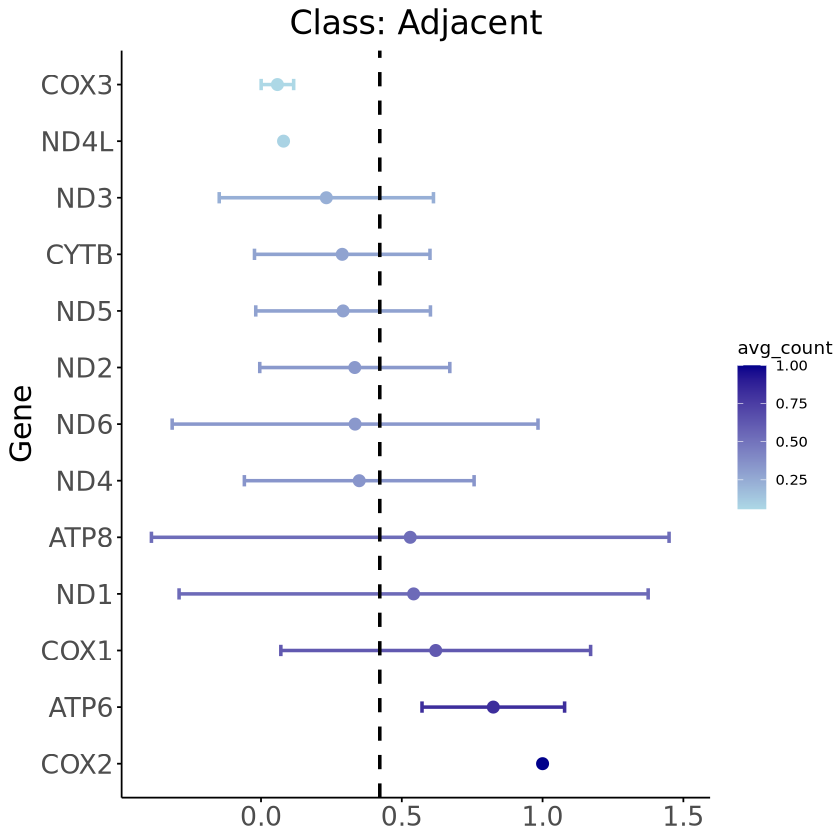

In [35]:
mean_avg_count <- mean(adjacent_stats$avg_count, na.rm = TRUE)
adjacent_plot <- ggplot(adjacent_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Adjacent") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +  # 不再需要 limits，使用默认
    scale_x_continuous(limits = x_limits) +  # 设置 X 轴范围
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题

print(adjacent_plot)

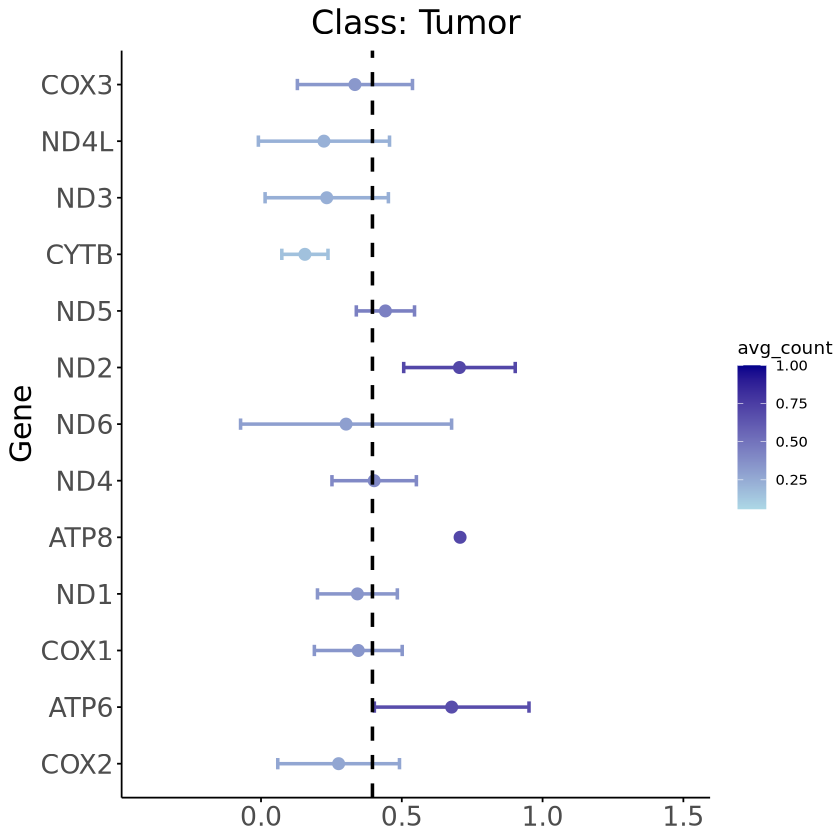

In [36]:
mean_avg_count <- mean(tumor_stats$avg_count, na.rm = TRUE)
# 创建 tumor_plot
tumor_plot <- ggplot(tumor_stats, aes(x = avg_count, y = Gene.MT_ensGene, color = avg_count)) +
    geom_point(size = 3) +
    geom_errorbar(aes(xmin = ci_lower, xmax = ci_upper), width = 0.2, size = 1) +
    geom_vline(xintercept = mean_avg_count, linetype = "dashed", color = "black", size = 1) +
    labs(y = "Gene", title = "Class: Tumor") +
    scale_color_gradient(low = "lightblue", high = "darkblue",limits = color_limits) +  # 不再需要 limits，使用默认
    scale_x_continuous(limits = x_limits) +  # 设置 X 轴范围
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"),
          axis.ticks = element_line(size = 0.5),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.title = element_text(size = 20, hjust = 0.5),
          axis.title.x = element_blank())  # 去掉 X 轴标题

print(tumor_plot)

In [37]:
library(patchwork)

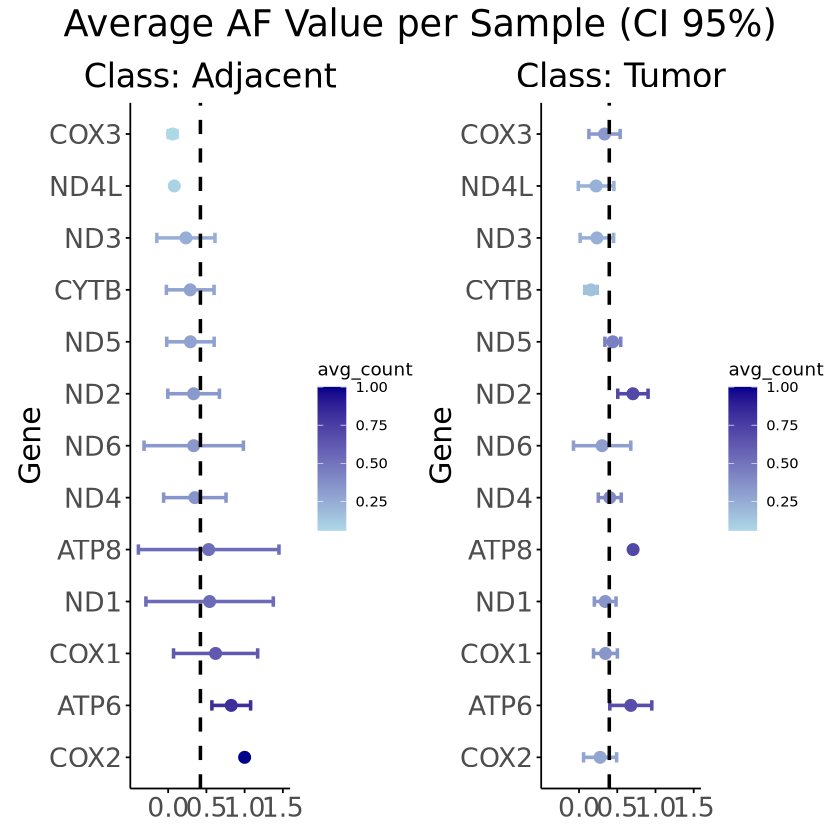

In [38]:

# 将两个图拼在一起，设置为一行
combined_plot <-  adjacent_plot + tumor_plot + plot_layout(ncol = 2) +
    plot_annotation(title = "Average AF Value per Sample (CI 95%)", 
                    theme = theme(plot.title = element_text(size = 22, hjust = 0.5)))

print(combined_plot)

In [39]:
ggsave("plots/AF value of per gene in per sample paired exon gene.pdf", plot = combined_plot, width = 10, height = 5,dpi=300)